In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#when using checkpoint:
!unzip drive/MyDrive/tapas_base_german_fine_tuned.zip -d .
!mv tapas_base_german_fine_tuned/vocab.txt .

Archive:  drive/MyDrive/tapas_base_german_fine_tuned.zip
  inflating: ./tapas_base_german_fine_tuned/config.json  
  inflating: ./tapas_base_german_fine_tuned/pytorch_model.bin  
  inflating: ./tapas_base_german_fine_tuned/vocab.txt  


In this notebook, we want to train a German TAPAS model by fine-tuning the google/tapas-base model.

As a prerequisite we need to install the transformers pip package.

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.4 MB/s eta 0:00:00


# Data Transformation

For training, we need to unpack the training data as well as transform it, so it can be processed during the pytorch training.

In [ ]:
!unzip sqa_data.zip

Archive:  sqa_data.zip
   creating: sqa_data/tables/
  inflating: sqa_data/tables/11111-0002.csv  
  inflating: sqa_data/tables/13111-0001.csv  
  inflating: sqa_data/tables/13111-0002.csv  
  inflating: sqa_data/tables/13111-0003.csv  
  inflating: sqa_data/tables/13111-0004.csv  
  inflating: sqa_data/tables/13111-0005.csv  
  inflating: sqa_data/tables/13111-0006.csv  
  inflating: sqa_data/tables/13211-0001.csv  
  inflating: sqa_data/tables/13211-0002.csv  
  inflating: sqa_data/tables/13211-0003.csv  
  inflating: sqa_data/tables/13211-0004.csv  
  inflating: sqa_data/tables/14111-0001.csv  
  inflating: sqa_data/tables/14111-0002.csv  
  inflating: sqa_data/tables/14111-0003.csv  
  inflating: sqa_data/tables/14111-0004.csv  
  inflating: sqa_data/tables/14121-0001.csv  
  inflating: sqa_data/tables/14121-0002.csv  
  inflating: sqa_data/tables/14121-0003.csv  
  inflating: sqa_data/tables/14121-0004.csv  
  inflating: sqa_data/tables/14121-0005.csv  
  inflating: sqa_data/table

In [ ]:
import pandas as pd
tsv_path = "sqa_data/training.csv"
data = pd.read_csv(tsv_path, sep=',')

In [ ]:
import ast

def _parse_answer_coordinates(answer_coordinate_str):
  """Parses the answer_coordinates of a question.
  Args:
    answer_coordinate_str: A string representation of a Python list of tuple
      strings.
      For example: "['(1, 4)','(1, 3)', ...]"
  """

  try:
    answer_coordinates = []
    # make a list of strings
    coords = ast.literal_eval(answer_coordinate_str)
    # parse each string as a tuple
    for row_index, column_index in sorted(
        ast.literal_eval(coord) for coord in coords):
      answer_coordinates.append((row_index, column_index))
  except SyntaxError:
    raise ValueError('Unable to evaluate %s' % answer_coordinate_str)

  return answer_coordinates


def _parse_answer_text(answer_text):
  try:
    answer_text = "['" + str(answer_text) + "']"
    answer = []
    for value in ast.literal_eval(answer_text):
        answer.append(value)
  except SyntaxError:
    raise ValueError('Unable to evaluate %s' % answer_text)

  return answer

data['answer_coordinates'] = data['answer_coordinates'].apply(lambda coords_str: _parse_answer_coordinates(coords_str))
data['answer_text'] = data['answer_text'].apply(lambda txt: _parse_answer_text(txt))

data.head(10)

,id,annotator,position,question,table_file,answer_coordinates,answer_text
0,11111-0002,0,0,Was ist die Gebietsfläche vom kreis Flensburg ...,tables/11111-0002.csv,"[(0, 2)]","[56,73]"
1,13111-0001,0,0,Wie viele Beschäftigte am Arbeitsort gab es fü...,tables/13111-0001.csv,"[(5, 3)]",[3596896]
2,13111-0003,0,0,Wie viele weliche sozialvers.pflichtig Beschäf...,tables/13111-0003.csv,"[(7, 3)]",[1737322]
3,13111-0003,1,0,Wie hoch war am 30.06.2020 die Anzahl der männ...,tables/13111-0003.csv,"[(3, 3)]",[55416]
4,13111-0001,1,0,In welcher Altersgruppe gab es zum Stichtag 30...,tables/13111-0001.csv,"[(10, 0)]",[25 bis unter 35 Jahre]
5,23121-0001,0,0,Wie hoch waren die bereinigten Kosten je Behan...,tables/23121-0001.csv,"[(6, 3)]",[21561]
6,11111-0002,1,0,Wie groß war die Gebietsfläche des Landkreises...,tables/11111-0002.csv,"[(4, 2)]","[1428,17]"
7,11111-0002,2,0,Zu welchem Stichtag war die Gebietsfläche in N...,tables/11111-0002.csv,"[(3, 0)]",[31.12.2020]
8,11111-0002,3,0,Wie viel Gebietsfläche hatte der Landkreis Her...,tables/11111-0002.csv,"[(5, 2)]","[1263,07]"
9,11111-0002,4,0,Wie groß war die Gebietsfläche in qkm zum Stic...,tables/11111-0002.csv,"[(7, 2)]","[1393,02]"


As larger tables do not really work with the model, we cut out all tables with more than 10 rows (found out by testing out).

In [ ]:
for index, row in data.iterrows():
  answer_coordinates = row["answer_coordinates"]
  table_file = row["table_file"]
  df = pd.read_csv("sqa_data/" + table_file)
  if df.shape[1] > 11:
    data = data.drop(index)

We then use a train test split with 20% of data used for testing later on.

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=7)

In [ ]:
len(test_data)

190

Afterwards we transform our dataset into a TableDataset wrapper that uses a German BERT vocabulary file (source: https://huggingface.co/bert-base-german-cased/blob/main/vocab.txt)

In [ ]:
from transformers import TapasTokenizer
vocab_file = 'vocab.txt'
custom_tokenizer = TapasTokenizer(vocab_file=vocab_file)

In [ ]:
import torch
import pandas as pd

tsv_path = "sqa_data/training.csv"
table_csv_path = "sqa_data/"

class TableDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
    def __getitem__(self, idx):
        item = data.iloc[idx]
        table = pd.read_csv(table_csv_path + item.table_file).astype(str) # be sure to make your table data text only
        encoding = self.tokenizer(table=table,
                                  queries=item.question,
                                  answer_coordinates=item.answer_coordinates,
                                  answer_text=item.answer_text,
                                  truncation=True,
                                  padding="max_length",
                                  return_tensors="pt"
        )
        # remove the batch dimension which the tokenizer adds by default
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        # add the float_answer which is also required (weak supervision for aggregation case)
        encoding["float_answer"] = torch.tensor(np.nan)
        return encoding
    def __len__(self):
       return len(self.data)

train_dataset = TableDataset(train_data, custom_tokenizer)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=13)

# Model Training

In [ ]:
from transformers import TapasConfig, TapasForQuestionAnswering, AdamW
import numpy as np

model = TapasForQuestionAnswering.from_pretrained("google/tapas-base")
device = torch.device("cuda")
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

loss_mean_epochs = []
loss_batches = []
for epoch in range(100):
   if len(loss_batches) > 0:
     loss_mean_epochs.append(np.mean(loss_batches))
     loss_mean_batches = []
   model.to("cuda")
   for idx, batch in enumerate(train_dataloader):
        print(f"Epoch {epoch}: Processing batch {idx + 1} / {len(train_dataloader)}...")
        # get the inputs;
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch["labels"].to(device)
        numeric_values = batch["numeric_values"].to(device)
        numeric_values_scale = batch["numeric_values_scale"].to(device)
        float_answer = batch["float_answer"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
                       labels=labels)
        loss = outputs.loss
        print(f"Loss: {loss.item()}")
        loss_batches.append(loss.item())
        loss.backward()
        optimizer.step()
   model.save_pretrained(f"./tapas_base_german_fine_tuned_{epoch}")

KeyboardInterrupt: ignored

Next we start our training in pytorch. We load the google/tapas-base model from hugging-face and set the model to cuda, so the model trains on the gpu instead of the cpu. This model will be fine-tuned via the AdamW optimizer on our training data.

When we print out the loss (both on the linear and logarithmic scala), we can see that the loss is gradually going down. After approximately 20 epochs though the loss is only going down slower than before. Therefore, considering our limited ressources, the training was stopped after 100 epochs.

Text(0, 0.5, 'Loss')

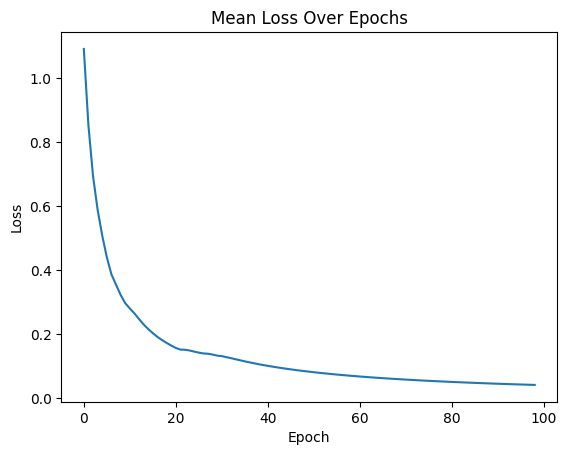

In [ ]:
plt.title("Mean Loss Over Epochs")
plt.plot(loss_mean_epochs)
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

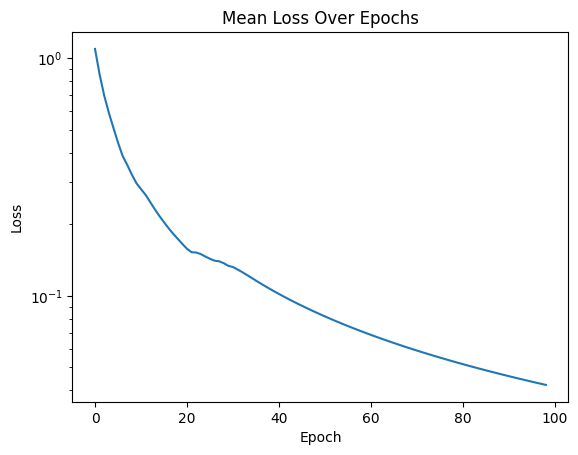

In [ ]:
import matplotlib.pyplot as plt

plt.title("Mean Loss Over Epochs")
plt.semilogy(loss_mean_epochs)
plt.xlabel("Epoch")
plt.ylabel("Loss")

Finally, we save our fine-tuned model.

In [ ]:
model.save_pretrained("./tapas_base_german_fine_tuned")

Some weights of TapasForQuestionAnswering were not initialized from the model checkpoint at google/tapas-base and are newly initialized: ['output_weights', 'column_output_bias', 'column_output_weights', 'output_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Validation

If the model is no longer within the Python environment, we reload both the model and its corresponding vocabulary file back into it.

In [ ]:
import torch
from transformers import TapasTokenizer, TapasForQuestionAnswering
model_trained = TapasForQuestionAnswering.from_pretrained("./tapas_base_german_fine_tuned")
device = torch.device("cuda")
model_trained.to(device)

TapasForQuestionAnswering(
  (tapas): TapasModel(
    (embeddings): TapasEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (token_type_embeddings_0): Embedding(3, 768)
      (token_type_embeddings_1): Embedding(256, 768)
      (token_type_embeddings_2): Embedding(256, 768)
      (token_type_embeddings_3): Embedding(2, 768)
      (token_type_embeddings_4): Embedding(256, 768)
      (token_type_embeddings_5): Embedding(256, 768)
      (token_type_embeddings_6): Embedding(10, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.07, inplace=False)
    )
    (encoder): TapasEncoder(
      (layer): ModuleList(
        (0-11): 12 x TapasLayer(
          (attention): TapasAttention(
            (self): TapasSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bia

In [ ]:
from transformers import TapasTokenizer, TapasForQuestionAnswering
import torch
import pandas as pd


vocab_file = 'vocab.txt'
custom_tokenizer = TapasTokenizer(vocab_file=vocab_file)

In [ ]:
from transformers import TapasTokenizer, TapasForQuestionAnswering
import pandas as pd


def load_model_and_tokenizer():
  """
    Load
  """
  # Load pretrained tokenizer: TAPAS finetuned on WikiTable Questions
  tokenizer = custom_tokenizer

  # Load pretrained model: TAPAS finetuned on WikiTable Questions
  model = global_model

  # Return tokenizer and model
  return tokenizer, model


def prepare_inputs(data, queries, tokenizer):
  inputs = tokenizer(table=data, queries=queries, padding='max_length', return_tensors="pt")
  return data, inputs


def generate_predictions(inputs, model, tokenizer):
  inputs = inputs.to("cuda")
  outputs = model(**inputs)

  # Convert logit outputs into predictions for table cells and aggregation operators
  predicted_table_cell_coords = tokenizer.convert_logits_to_predictions(
          inputs.to("cpu"),
          outputs.logits.cpu().detach()
  )


  return predicted_table_cell_coords


def postprocess_predictions(predicted_table_cell_coords, table):
  answers = []
  for coordinates in predicted_table_cell_coords[0]:
    if len(coordinates) == 1:
      #1 cell
      answers.append(table.iat[coordinates[0]])
    else:
      #> 1 cell
      cell_values = []
      for coordinate in coordinates:
        if not len(coordinate) == 0:
            cell_values.append(table.iat[coordinate])
      answers.append(", ".join(cell_values))
  return answers


def show_answers(queries, answers):
  for query, answer in zip(queries, answers):
    print(query)
    print("Predicted answer: " + answer)

def run_tapas(data, queries):
  tokenizer, model = load_model_and_tokenizer()
  table, inputs = prepare_inputs(data, queries, tokenizer)
  predicted_table_cell_coords = generate_predictions(inputs, model, tokenizer)
  answers = postprocess_predictions(predicted_table_cell_coords, table)
  show_answers(queries, answers)
  return predicted_table_cell_coords

def run_tapas_tokens(data, queries):
  tokenizer, model = load_model_and_tokenizer()
  table, inputs = prepare_inputs(data, queries, tokenizer)
  predicted_table_cell_coords = generate_predictions(inputs, model, tokenizer)
  answers = postprocess_predictions(predicted_table_cell_coords, table)
  #show_answers(queries, answers)
  return answers

## Development of Accuracies Over Epochs

We trained our model for 100 epochs and saved the model for every second epoch as a checkpoint. Now we reread the models and check their respective performance gain for every second epoch.


First we have to extract the saved models from drive.

In [ ]:
import os, zipfile

dir_name = '/content/drive/MyDrive'
extension = ".zip"

os.chdir(dir_name)

for item in os.listdir(dir_name):
    if item.endswith(extension):
        file_name = os.path.abspath(item)
        zip_ref = zipfile.ZipFile(file_name)
        zip_ref.extractall("/content/")
        zip_ref.close()

In [ ]:
from transformers import TapasTokenizer, TapasForQuestionAnswering
import torch
import pandas as pd

device = torch.device("cuda")
global_model = TapasForQuestionAnswering.from_pretrained(f"./tapas_base_german_fine_tuned_epoch_{epoch}")
global_model.to(device)
vocab_file = 'vocab.txt'
custom_tokenizer = TapasTokenizer(vocab_file=vocab_file)

OSError: ignored

In [ ]:
predicted_coordinates = []
for epoch in range(0, 100):
  predicted_coordinates.append([])
  real_coordinates = []
  global_model = model_trained
  for index, test_entry in test_data.iterrows():
      table = pd.read_csv("sqa_data/" + test_entry["table_file"]).astype(str)
      queries = [test_entry["question"]]
      predicted_coordinates[epoch].append(run_tapas(table, queries)[0][0])
      real_coordinates.append(test_entry["answer_coordinates"])

In [ ]:
predicted_coordinates = []
for epoch in range(0, 100):
  predicted_coordinates.append([])
  real_coordinates = []
  global_model = model_trained
  for index, test_entry in test_data.iterrows():
      table = pd.read_csv("sqa_data/" + test_entry["table_file"]).astype(str)
      queries = [test_entry["question"]]
      predicted_coordinates[epoch].append(run_tapas(table, queries)[0][0])
      real_coordinates.append(test_entry["answer_coordinates"])

## Evaluation of Determinism of the TAPAS Model

In [ ]:
predicted_coordinates = []

In [ ]:
for i in range(0, 30):
  predicted_coordinates.append([])
  real_coordinates = []
  global_model = model_trained
  for index, test_entry in test_data.iterrows():
      table = pd.read_csv("sqa_data/" + test_entry["table_file"]).astype(str)
      queries = [test_entry["question"]]
      predicted_coordinates[i].append(run_tapas(table, queries)[0][0])
      real_coordinates.append(test_entry["answer_coordinates"])

<class 'transformers.tokenization_utils_base.BatchEncoding'>
Wie viele geringfügig entlohnte Beschäftigte gab es 2019 im zulassungspflichtigem Handwerk?
Predicted answer: 430241
<class 'transformers.tokenization_utils_base.BatchEncoding'>
Was ist der Anteil gültiger Zweitstimmen für die Partei Christlich Demokratische Union Deutschland in Baden Württemberg in den Altersgruppen 60 bis unter 70 Jahren und mit weiblichem Geschlecht?
Predicted answer: 27,7
<class 'transformers.tokenization_utils_base.BatchEncoding'>
Wie hoch war am 01.01.2015 der Ausstattungsgrad von DVD- oder Blue-ray-Geräten bei Arbeitnehmern?
Predicted answer: 77,1
<class 'transformers.tokenization_utils_base.BatchEncoding'>
In welchem Bundesland lag der Verbraucherpreisindex im Jahr 1995 bei 75,0?
Predicted answer: Nordrhein-Westfalen
<class 'transformers.tokenization_utils_base.BatchEncoding'>
Wie viele MWh Elektrizität wurden 2021 durch Steinkohlen erzeugt?
Predicted answer: 46662271
<class 'transformers.tokenization

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors.


Streaming output truncated to the last 5000 lines.
Bei welchem Gebrauchsgut betrug der Ausstattungsgrad bei den 18 bis unter 25 Jährigen zum Stichtag 01.01.2011 76 Prozent?
Predicted answer: Digitalkamera (Fotoapparat digital)
<class 'transformers.tokenization_utils_base.BatchEncoding'>
Wie hoch ist der Anteil gültiger Zweitstimmen bei den 45 bis unter 60 Jährigen bei der Sozialdemokratischen Partei Deutschlands zum Stichtag 26.09.2021?
Predicted answer: 25,4
<class 'transformers.tokenization_utils_base.BatchEncoding'>
Wie viele verwertete inländische Rohstoffentnahmen gab es beim Erdöl im Jahr 2020?
Predicted answer: 1907
<class 'transformers.tokenization_utils_base.BatchEncoding'>
Zu welcher Rechtsform gehören Landwirtschaftliche Betriebe
Predicted answer: Einzelunternehmen, Haupterwerb
<class 'transformers.tokenization_utils_base.BatchEncoding'>
Wie viele Arbeitslose gab es im insgesamten Deutschland und allen Geschlechtern im Monat November und Jahr 2021?
Predicted answer: 2317067


In [ ]:
import pickle
file_pi1 = open('real_coordinates.pickle', 'wb')
pickle.dump(real_coordinates, file_pi1)

In [ ]:
for i in range(0, 30):
  correctly_calculated = 0
  for j in range(0, len(real_coordinates)):
    correctly_calculated += 1 if real_coordinates[j] == predicted_coordinates[i][j] else 0
  print(f"Accuracy Run {i} : {correctly_calculated / len(real_coordinates)}")

Accuracy Run 0 : 0.9315789473684211
Accuracy Run 1 : 0.9315789473684211
Accuracy Run 2 : 0.9315789473684211
Accuracy Run 3 : 0.9315789473684211
Accuracy Run 4 : 0.9315789473684211
Accuracy Run 5 : 0.9315789473684211
Accuracy Run 6 : 0.9315789473684211
Accuracy Run 7 : 0.9315789473684211
Accuracy Run 8 : 0.9315789473684211
Accuracy Run 9 : 0.9315789473684211
Accuracy Run 10 : 0.9315789473684211
Accuracy Run 11 : 0.9315789473684211
Accuracy Run 12 : 0.9315789473684211
Accuracy Run 13 : 0.9315789473684211
Accuracy Run 14 : 0.9315789473684211
Accuracy Run 15 : 0.9315789473684211
Accuracy Run 16 : 0.9315789473684211
Accuracy Run 17 : 0.9315789473684211
Accuracy Run 18 : 0.9315789473684211
Accuracy Run 19 : 0.9315789473684211
Accuracy Run 20 : 0.9315789473684211
Accuracy Run 21 : 0.9315789473684211
Accuracy Run 22 : 0.9315789473684211
Accuracy Run 23 : 0.9315789473684211
Accuracy Run 24 : 0.9315789473684211
Accuracy Run 25 : 0.9315789473684211
Accuracy Run 26 : 0.9315789473684211
Accuracy Ru

## Fine Tuned Model

First, we want to validate the fine tuned model. We input the test data into the model and save the results.

In [ ]:
predicted_coordinates = []
real_coordinates = []

global_model = model_trained
for index, test_entry in test_data.iterrows():
    table = pd.read_csv("sqa_data/" + test_entry["table_file"]).astype(str)
    queries = [test_entry["question"]]
    predicted_coordinates.append(run_tapas(table, queries)[0][0])
    real_coordinates.append(test_entry["answer_coordinates"])

Wie viele geringfügig entlohnte Beschäftigte gab es 2019 im zulassungspflichtigem Handwerk?
Predicted answer: 430241
Was ist der Anteil gültiger Zweitstimmen für die Partei Christlich Demokratische Union Deutschland in Baden Württemberg in den Altersgruppen 60 bis unter 70 Jahren und mit weiblichem Geschlecht?
Predicted answer: 27,7
Wie hoch war am 01.01.2015 der Ausstattungsgrad von DVD- oder Blue-ray-Geräten bei Arbeitnehmern?
Predicted answer: 77,1
In welchem Bundesland lag der Verbraucherpreisindex im Jahr 1995 bei 75,0?
Predicted answer: Nordrhein-Westfalen
Wie viele MWh Elektrizität wurden 2021 durch Steinkohlen erzeugt?
Predicted answer: 46662271
Wie viele Tsd. EUR Nettoausgaben gab es 2021 bei der Hilfe zur Pflege?
Predicted answer: 4736937
Wie viel Fläche wurde zum 31.12.1992 als Verkehrsfläche genutzt?
Predicted answer: 16440,840
Wie hoch war der Beschäftigtenindex im März 2022 bei ausgewählten Dienstleistungsbereichen und Gastgewerbe?
Predicted answer: 104,5
Wie viele Schüle

In [ ]:
predicted_cell_text = []
real_cell_text = []

global_model = model_trained
for index, test_entry in test_data.iterrows():
    table = pd.read_csv("sqa_data/" + test_entry["table_file"]).astype(str)
    queries = [test_entry["question"]]
    predicted_coordinates = run_tapas(table, queries)[0][0]
    real_coordinates = test_entry["answer_coordinates"]
    print(predicted_coordinates)
    print(real_coordinates)
    if(len(predicted_coordinates) > 0):
      predicted_cell_text.append(table.iloc[predicted_coordinates[0]])
    else:
      predicted_cell_text.append("")
    real_cell_text.append(table.iloc[real_coordinates[0]])

Wie viele geringfügig entlohnte Beschäftigte gab es 2019 im zulassungspflichtigem Handwerk?
Predicted answer: 430241
[(5, 10)]
[(5, 10)]
Was ist der Anteil gültiger Zweitstimmen für die Partei Christlich Demokratische Union Deutschland in Baden Württemberg in den Altersgruppen 60 bis unter 70 Jahren und mit weiblichem Geschlecht?
Predicted answer: 27,7
[(10, 2)]
[(10, 2)]
Wie hoch war am 01.01.2015 der Ausstattungsgrad von DVD- oder Blue-ray-Geräten bei Arbeitnehmern?
Predicted answer: 77,1
[(9, 1)]
[(9, 1)]
In welchem Bundesland lag der Verbraucherpreisindex im Jahr 1995 bei 75,0?
Predicted answer: Nordrhein-Westfalen
[(7, 2)]
[(7, 2)]
Wie viele MWh Elektrizität wurden 2021 durch Steinkohlen erzeugt?
Predicted answer: 46662271
[(0, 2)]
[(0, 2)]
Wie viele Tsd. EUR Nettoausgaben gab es 2021 bei der Hilfe zur Pflege?
Predicted answer: 4736937
[(2, 0)]
[(2, 0)]
Wie viel Fläche wurde zum 31.12.1992 als Verkehrsfläche genutzt?
Predicted answer: 16440,840
[(3, 0)]
[(3, 0)]
Wie hoch war der B

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors.


Wie viele Tsd. Arbeitsstunden wurden im Januar 2022 im Bauhauptgewerbe in Betrieben mit 20 und mehr tätigen Personen geleistet?
Predicted answer: 38156
[(0, 5)]
[(0, 5)]
Wie viele Versorgungszugänge der männlichen Empfänger gab es 2020 in der Besoldungsgruppe A 14 - B 11, R, W, C?
Predicted answer: 15
[(9, 0)]
[(9, 0)]
Wie hoch war der Umsatz im Großhandel im Mai 2022 in Berlin?
Predicted answer: 96,5
[(10, 4)]
[(10, 4)]
Was sind die bereinigten Kosten je Behandlungsfall in Euro im Jahr 1994?
Predicted answer: 19361
[(3, 3)]
[(3, 3)]
Wie hoch war zum 04/2018 der Anteil abhängiger Beschäftigungsverhältnisse mit Niedriglohn bei Männern im Gastgewerbe?
Predicted answer: 61,0
[(6, 2)]
[(6, 2)]
Wie hoch war die Veränderung zum Vorjahresmonat im März 2021?
Predicted answer: +1,7
[(2, 2)]
[(2, 2)]
Wie viele Tausend gültige Zweitstimmen erhielt die Christlich Demokratische Union Deutschlands zum 26.09.2021 in Baden-Württemberg von den 45 bis unter 60 Jährigen?
Predicted answer: 345,1
[(9, 5)]


### F1 Score

In [ ]:
precision_values = []
recall_values = []

for entry_i in range(0, len(predicted_cell_text)):
  predicted_tokens = custom_tokenizer.tokenize(predicted_cell_text[entry_i])
  real_tokens = custom_tokenizer.tokenize(real_cell_text[entry_i])
  common = collections.Counter(real_tokens) & collections.Counter(predicted_tokens)
  print(common.values())
  num_same_tokens = sum(common.values())
  if(len(predicted_tokens) > 0):
    precision_values.append(num_same_tokens / len(predicted_tokens))
  else:
    precision_values.append(0)
  recall_values.append(num_same_tokens / len(real_tokens))

precision_mean = np.mean(precision_values)
recall_mean = np.mean(recall_values)

dict_values([1, 1, 1])
dict_values([1, 1, 1])
dict_values([1, 1, 1])
dict_values([1, 1, 1, 1])
dict_values([1, 1, 1, 1])
dict_values([1, 1, 1, 1])
dict_values([1, 1, 2, 1, 1])
dict_values([1, 1, 1])
dict_values([1, 1])
dict_values([1, 1, 1])
dict_values([1, 1, 1])
dict_values([1, 1])
dict_values([1, 1, 1, 1])
dict_values([1, 1, 1, 1])
dict_values([1, 1, 1])
dict_values([1, 1, 1, 1, 1])
dict_values([1, 1, 1])
dict_values([1])
dict_values([1, 1, 1])
dict_values([1])
dict_values([1, 1, 1])
dict_values([1, 1, 1, 1])
dict_values([1])
dict_values([1, 1])
dict_values([1, 1, 1, 1])
dict_values([1])
dict_values([1, 1, 1, 1])
dict_values([1, 1, 1])
dict_values([1, 1, 1])
dict_values([1, 1, 1])
dict_values([1, 1])
dict_values([])
dict_values([1])
dict_values([1, 1, 1, 1])
dict_values([1, 1, 1])
dict_values([1, 1, 1])
dict_values([1, 1, 1, 1])
dict_values([1, 1, 1, 1])
dict_values([1, 2, 2])
dict_values([1, 1])
dict_values([1, 1, 1, 1])
dict_values([1, 1, 1])
dict_values([1, 1, 1, 1, 1])
dict_valu

In [ ]:
recall_mean

0.9451754385964911

In [ ]:
precision_mean

0.9451754385964911

TODO: find out how to handle mutliple predictions

###Accuracy With Tolerance
In the following the accuracy is calculated that a prediction is correct if at least one tuple in the prediction is correct.

In [ ]:
correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
   correctly_calculated += 1 if real_coordinates[i][0] in predicted_coordinates[i] else 0
print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Accuracy: 0.9473684210526315


###Denotation Accuracy
In the following the accuracy is calculated based on the denotation accuracy which refers to the ground truth.

In [ ]:
correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
   correctly_calculated += 1 if real_coordinates[i] == predicted_coordinates[i] else 0
print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Accuracy: 0.9315789473684211


In [ ]:
correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
   correctly_calculated += 1 if real_coordinates[i] == predicted_coordinates[0][i] else 0
print(f"Accuracy: {correctly_calculated / len(predicted_coordinates[0])}")

Accuracy: 0.05


## Original Model With German Vocab File

Next, we want to validate the original model together with the german vocabulary file. We input the test data into the model and save the results.

In [ ]:
from transformers import TapasTokenizer, TapasForQuestionAnswering
predicted_coordinates = []
real_coordinates = []

global_model = TapasForQuestionAnswering.from_pretrained("google/tapas-base-finetuned-sqa")
for index, test_entry in test_data.iterrows():
    table = pd.read_csv("sqa_data/" + test_entry["table_file"]).astype(str)
    queries = [test_entry["question"]]
    predicted_coordinates.append(run_tapas(table, queries)[0][0])
    real_coordinates.append(test_entry["answer_coordinates"])

Wie viele geringfügig entlohnte Beschäftigte gab es 2019 im zulassungspflichtigem Handwerk?
Predicted answer: 41782139, 57852565, 84185504, 120267200, 273545530, 577632938, 7232114, 11711711, 19078308, 26966901, 52068538
Was ist der Anteil gültiger Zweitstimmen für die Partei Christlich Demokratische Union Deutschland in Baden Württemberg in den Altersgruppen 60 bis unter 70 Jahren und mit weiblichem Geschlecht?
Predicted answer: Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands
Wie hoch war am 01.01.2015 der Ausstattungsgrad von DVD- oder Blue-ray-G

In [ ]:
predicted_cell_text = []
real_cell_text = []

global_model = TapasForQuestionAnswering.from_pretrained("google/tapas-base-finetuned-sqa").to(device)
for index, test_entry in test_data.iterrows():
    table = pd.read_csv("sqa_data/" + test_entry["table_file"]).astype(str)
    queries = [test_entry["question"]]
    predicted_coordinates = run_tapas(table, queries)[0][0]
    real_coordinates = test_entry["answer_coordinates"]
    print(predicted_coordinates)
    print(real_coordinates)
    if(len(predicted_coordinates) > 0):
      predicted_cell_text.append(table.iloc[predicted_coordinates[0]])
    else:
      predicted_cell_text.append("")
    real_cell_text.append(table.iloc[real_coordinates[0]])

Wie viele geringfügig entlohnte Beschäftigte gab es 2019 im zulassungspflichtigem Handwerk?
Predicted answer: 41782139, 57852565, 84185504, 120267200, 273545530, 577632938, 7232114, 11711711, 19078308, 26966901, 52068538
[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0)]
[(5, 10)]
Was ist der Anteil gültiger Zweitstimmen für die Partei Christlich Demokratische Union Deutschland in Baden Württemberg in den Altersgruppen 60 bis unter 70 Jahren und mit weiblichem Geschlecht?
Predicted answer: Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demokratische Union Deutschlands, Christlich Demok

###F1 Score

In [ ]:
precision_values = []
recall_values = []

for entry_i in range(0, len(predicted_cell_text)):
  predicted_tokens = custom_tokenizer.tokenize(predicted_cell_text[entry_i])
  real_tokens = custom_tokenizer.tokenize(real_cell_text[entry_i])
  common = collections.Counter(real_tokens) & collections.Counter(predicted_tokens)
  print(common.values())
  num_same_tokens = sum(common.values())
  if(len(predicted_tokens) > 0):
    precision_values.append(num_same_tokens / len(predicted_tokens))
  else:
    precision_values.append(0)
  recall_values.append(num_same_tokens / len(real_tokens))

precision_mean = np.mean(precision_values)
recall_mean = np.mean(recall_values)

dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([1])
dict_values([1, 1, 1, 1])
dict_values([1, 1])
dict_values([])
dict_values([1])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([1, 1])
dict_values([])
dict_values([1, 1, 1, 1])
dict_values([])
dict_values([])
dict_values([1, 1, 1])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([1, 1])
dict_values([1])
dict_values([1])
dict_values([1, 1, 1, 1])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([1])
dict_values([])
dict_values([])
dict_values([])
dict_values([1, 1])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([])
dict_values([]

In [ ]:
recall_mean

0.1732456140350877

In [ ]:
precision_mean

0.17192982456140354

###Accuracy With Tolerance
In the following the accuracy is calculated that a prediction is correct if at least one tuple in the prediction is correct.

In [ ]:
correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
   correctly_calculated += 1 if real_coordinates[i][0] in predicted_coordinates[i] else 0
print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Accuracy: 0.3631578947368421


###Denotation Accuracy
In the following the accuracy is calculated based on the denotation accuracy which refers to the ground truth.

In [ ]:
correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
   correctly_calculated += 1 if real_coordinates[i] == predicted_coordinates[i] else 0
print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Accuracy: 0.07894736842105263


## Original Model With Original Tokenizer

Next, we want to validate the original model together with the original vocabulary file. We input the test data into the model and save the results.

In [ ]:
from transformers import AutoTokenizer
custom_tokenizer = AutoTokenizer.from_pretrained("google/tapas-base-finetuned-sqa")
predicted_coordinates = []
real_coordinates = []

global_model = TapasForQuestionAnswering.from_pretrained("google/tapas-base-finetuned-sqa")

In [ ]:
from transformers import AutoTokenizer
custom_tokenizer = AutoTokenizer.from_pretrained("google/tapas-base-finetuned-sqa")
predicted_coordinates = []
real_coordinates = []

global_model = TapasForQuestionAnswering.from_pretrained("google/tapas-base-finetuned-sqa")
for index, test_entry in test_data.iterrows():
    table = pd.read_csv("sqa_data/" + test_entry["table_file"]).astype(str)
    queries = [test_entry["question"]]
    predicted_coordinates.append(run_tapas(table, queries)[0][0])
    real_coordinates.append(test_entry["answer_coordinates"])

Token indices sequence length is longer than the specified maximum sequence length for this model (636 > 512). Running this sequence through the model will result in indexing errors.


Wie viele geringfügig entlohnte Beschäftigte gab es 2019 im zulassungspflichtigem Handwerk?
Predicted answer: 
Was ist der Anteil gültiger Zweitstimmen für die Partei Christlich Demokratische Union Deutschland in Baden Württemberg in den Altersgruppen 60 bis unter 70 Jahren und mit weiblichem Geschlecht?
Predicted answer: 39,8
Wie hoch war am 01.01.2015 der Ausstattungsgrad von DVD- oder Blue-ray-Geräten bei Arbeitnehmern?
Predicted answer: 
In welchem Bundesland lag der Verbraucherpreisindex im Jahr 1995 bei 75,0?
Predicted answer: Baden-Württemberg, Nordrhein-Westfalen
Wie viele MWh Elektrizität wurden 2021 durch Steinkohlen erzeugt?
Predicted answer: 46662271
Wie viele Tsd. EUR Nettoausgaben gab es 2021 bei der Hilfe zur Pflege?
Predicted answer: 4736937
Wie viel Fläche wurde zum 31.12.1992 als Verkehrsfläche genutzt?
Predicted answer: 16440,840
Wie hoch war der Beschäftigtenindex im März 2022 bei ausgewählten Dienstleistungsbereichen und Gastgewerbe?
Predicted answer: +1,4, +1,6, +

###Accuracy With Tolerance
In the following the accuracy is calculated that a prediction is correct if at least one tuple in the prediction is correct.

In [ ]:
correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
   correctly_calculated += 1 if real_coordinates[i][0] in predicted_coordinates[i] else 0
print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Accuracy: 0.5578947368421052


###Denotation Accuracy
In the following the accuracy is calculated based on the denotation accuracy which refers to the ground truth.

In [ ]:
correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
   correctly_calculated += 1 if real_coordinates[i] == predicted_coordinates[i] else 0
print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Accuracy: 0.45263157894736844


## Original Model With Original Tokenizer And Translated Test Data

Next, we want to try out the original model but this time translate the tables with the help of DeepL. With that we want to verify if just translating gives us the same results as the fined tuned model or even better ones.

In [ ]:
pip install deepl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### DeepL Translation

First we write functions that helps us to translate dataframes.

In [ ]:
import deepl
deepl_auth_key = "3ba8b4fe-d3c5-94f3-aec0-816821af15df:fx"
translator = deepl.Translator(deepl_auth_key)

In [ ]:
def translate_text(text):
  translated_object = translator.translate_text(text, target_lang="EN-US")
  return translated_object.text if hasattr(translated_object, "text") else "Translation failed."

In [ ]:
def translate_dataframe(df):
    translated_df = df.copy()
    translated_df.columns = [translate_text(col) for col in translated_df.columns]
    for col in translated_df.columns:
        translated_df[col] = translated_df[col].apply(lambda x: translate_text(x))
    return translated_df

Now we translate all questions and save these to save ressources later on.

In [ ]:
questions = test_data['question']
test_data['question'] = questions.apply(translator.translate_text, target_lang="EN-US").apply(lambda translated_object: translated_object.text if hasattr(translated_object, "text") else "Translation failed.")

In [ ]:
file = open("predicted_coordinates_model_checkpoints.pickle", "rb")

EOFError: ignored

Next we do the same for tables.

In [ ]:
translated_tables = dict()
for index, test_entry in test_data.iterrows():
    table = pd.read_csv("sqa_data/" + test_entry["table_file"]).astype(str)
    if test_entry["table_file"] not in translated_tables:
      table = translate_dataframe(table)
      translated_tables[test_entry["table_file"]] = table.astype(str)

In [ ]:
import pickle
fileObj = open('translated_tables_dict', 'wb')
pickle.dump(translated_tables, fileObj)
fileObj.close()

###Validation
Next, we evaluate the translated questions and save the results.

In [ ]:
error_per_table = dict()

In [ ]:
from transformers import AutoTokenizer
custom_tokenizer = AutoTokenizer.from_pretrained("google/tapas-base-finetuned-sqa")
predicted_coordinates = []
real_coordinates = []

global_model = TapasForQuestionAnswering.from_pretrained("google/tapas-base-finetuned-sqa")
for index, test_entry in test_data.iterrows():
    table = translated_tables[test_entry["table_file"]].astype(str)
    queries = [test_entry["question"]]
    predicted_coordinates.append(run_tapas(table, queries)[0][0])


    if test_entry["table_file"] not in error_per_table:
        error_per_table[test_entry["table_file"]] = 0
    if not real_coordinates == predicted_coordinates:
        error_per_table[test_entry["table_file"]] += 1

    real_coordinates.append(test_entry["answer_coordinates"])

How many marginally paid employees were there in the trade subject to registration in 2019?
Predicted answer: 41782139, 57852565, 84185504, 120267200, 273545530, 577632938, 7232114, 11711711, 19078308, 26966901, 52068538
What is the proportion of valid second votes for the Christian Democratic Union of Germany party in Baden Württemberg in the age groups 60 to under 70 and with female gender?
Predicted answer: 
What was the level of DVD or Blu-ray equipment among employees on 01/01/2015?
Predicted answer: 77,1, 24,2
In which state was the consumer price index 75.0 in 1995?
Predicted answer: Baden-Württemberg
How many MWh of electricity were generated by hard coal in 2021?
Predicted answer: 51105726
How many thousand euros of net expenditures were there in 2021 for assistance for long-term care?
Predicted answer: 4736937
How much area was used as traffic area as of 31.12.1992?
Predicted answer: 20733,340
What was the March 2022 employment index for selected service and hospitality indus

###Accuracy With Tolerance
In the following the accuracy is calculated that a prediction is correct if at least one tuple in the prediction is correct.

In [ ]:
correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
   correctly_calculated += 1 if real_coordinates[i][0] in predicted_coordinates[i] else 0
print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Accuracy: 0.7631578947368421


###Denotation Accuracy

In [ ]:
correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
   correctly_calculated += 1 if real_coordinates[i] == predicted_coordinates[i] else 0
print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Accuracy: 0.43157894736842106


###Error Per Table

In [ ]:
import matplotlib.pyplot as plt

dict(sorted(error_per_table.items(), key=lambda item: item[1]))

{'tables/53111-0003.csv': 1,
 'tables/43311-0001.csv': 1,
 'tables/22111-0003.csv': 1,
 'tables/33111-0005.csv': 1,
 'tables/47414-0002.csv': 1,
 'tables/73111-0002.csv': 1,
 'tables/61111-0001.csv': 1,
 'tables/22111-0013.csv': 1,
 'tables/23121-0002.csv': 1,
 'tables/43111-0001.csv': 1,
 'tables/41122-0001.csv': 1,
 'tables/85111-0001.csv': 1,
 'tables/47414-0006.csv': 1,
 'tables/33111-0006.csv': 1,
 'tables/62111-0011.csv': 1,
 'tables/53111-0002.csv': 1,
 'tables/63111-0005.csv': 1,
 'tables/14121-0002.csv': 1,
 'tables/85131-0004.csv': 1,
 'tables/13211-0004.csv': 1,
 'tables/13111-0006.csv': 1,
 'tables/46131-0008.csv': 1,
 'tables/43111-0002.csv': 1,
 'tables/52111-0013.csv': 1,
 'tables/14111-0002.csv': 1,
 'tables/24221-0001.csv': 1,
 'tables/14121-0001.csv': 1,
 'tables/22111-0014.csv': 1,
 'tables/73151-0001.csv': 1,
 'tables/85111-0002.csv': 1,
 'tables/46131-0003.csv': 1,
 'tables/45211-0001.csv': 1,
 'tables/62111-0005.csv': 1,
 'tables/41141-0002.csv': 1,
 'tables/44111

##Unstructured Validation

Next, we want to use a self-created dataset the model was not trained on. To achieve this, we are utilizing tables extracted from the Hypo Vorarlberg sustainability report. In the initial phase, our approach involves attempting to directly utilize the unprocessed extracted tables without any human intervention. As a result, the tables may appear somewhat disorganized or untidy.

In [ ]:
!unzip transformed_tables.zip

Archive:  transformed_tables.zip
  inflating: 59 1.csv                
  inflating: 61.csv                  
  inflating: 59 2.csv                
  inflating: 49.csv                  
  inflating: 60.csv                  
  inflating: Nachhaltigkeitsbericht-2021_Hypo-Vorarlberg.pdf  
  inflating: 62.csv                  
  inflating: 59 4.csv                
  inflating: 59 3.csv                
  inflating: 47 3.csv                
  inflating: 22.csv                  
  inflating: 47 2.csv                
  inflating: 47.csv                  


An unstructured table could look like this for example:

In [ ]:
table = pd.read_csv(validation_data["file_path"][10])
table

,Unnamed: 0,0,1,2,3,4,5,6
0,0,Mitarbeiterkennzahlen (nach Köpfen zum Bericht...,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,2021,NaN,2020,NaN,2019,NaN
2,2,NaN,Konzern,Bank,Konzern,Bank,Konzern,Bank
3,3,Mitarbeiter gesamt,876,778,877,779,881,731
4,4,Frauen,497,443,494,438,502,438
5,5,Männer,379,335,383,341,379,293
6,6,Vollzeit,585,525,595,536,603,496
7,7,Frauen,235,215,244,223,252,223
8,8,Männer,350,310,351,313,351,273
9,9,Teilzeit,230,198,224,189,208,172


In [ ]:
validation_data = pd.read_csv("unstructured_table_dataset.csv")
validation_data

,Unnamed: 0,file_path,question,answer_coordinates
0,0,22.csv,Was ist der Anteil am Umsatz in Deutschland in...,"(5, 3)"
1,1,22.csv,Was ist der Anteil am Umsatz in Österreich in ...,"(4, 4)"
2,2,22.csv,Was ist der Anteil am Umsatz in der Schweiz in...,"(6, 2)"
3,3,22.csv,Was ist der Anteil am Umsatz in der Schweiz in...,"(6, 3)"
4,4,22.csv,Was ist der Anteil am Umsatz in der Schweiz in...,"(6, 4)"
...,...,...,...,...
95,95,62.csv,Wie hoch war der Wasserverbrauch gesamt in 202...,"(4, 2)"
96,96,62.csv,Wie hoch war der Wasserverbrauch gesamt in 202...,"(4, 3)"
97,97,62.csv,Wie hoch war der Wasserverbrauch gesamt in 201...,"(4, 8)"
98,98,62.csv,Wie hoch war der Restmüll-Output im Jahr 2021 ...,"(7, 2)"


In [ ]:
import pandas as pd

predicted_coordinates = []
real_coordinates = []
validation_data = pd.read_csv("unstructured_table_dataset.csv")


global_model = model_trained
for index, test_entry in validation_data.iterrows():
    table = pd.read_csv(test_entry["file_path"]).astype(str)
    queries = [test_entry["question"]]
    predicted_coordinates.append(run_tapas(table, queries)[0][0])
    real_coordinates.append(test_entry["answer_coordinates"])

Was ist der Anteil am Umsatz in Deutschland in Euro im Jahr 2020?
Predicted answer: 2019
Was ist der Anteil am Umsatz in Österreich in Euro im Jahr 2019?
Predicted answer: 2020, 90,24%
Was ist der Anteil am Umsatz in der Schweiz in Euro im Jahr 2021?
Predicted answer: 2020
Was ist der Anteil am Umsatz in der Schweiz in Euro im Jahr 2020?
Predicted answer: nan
Was ist der Anteil am Umsatz in der Schweiz in Euro im Jahr 2019?
Predicted answer: 2020
Was ist der Anteil am Umsatz in Österreich in Euro im Jahr 2020?
Predicted answer: 2019, 90,99%
Was ist der Anteil am Umsatz in Deutschland in Euro im Jahr 2019?
Predicted answer: 2020
Wie viele weibliche / Frauen Mitarbeiter  gab es 2021 in der Vollzeit im Konzern?
Predicted answer: Konzern
Wie viele weibliche / Frauen Mitarbeiter gab es 2021 in der Vollzeit in der Bank?
Predicted answer: 2020, 595
Wie viele männliche / Männer Mitarbeiter gab es 2020 in der Vollzeit in der Bank?
Predicted answer: 585
Wie viele männliche / Männer Mitarbeiter g

Token indices sequence length is longer than the specified maximum sequence length for this model (698 > 512). Running this sequence through the model will result in indexing errors.


Wie hoch waren die direkten THG-Emissionen (Scope 1) innerhalb der Bank in 2016?
Predicted answer: -86, nan
Wie hoch war der Energieverbrauch für die Heizenergie im Konzern in 2020?
Predicted answer: Konzern
Wie hoch war der Energieverbrauch für die Heizenergie im Konzern in 2021?
Predicted answer: Konzern
Wie hoch war der Energieverbrauch für die Heizenergie in der Bank in 2021?
Predicted answer: nan, 1.788.296
Wie hoch war der Energieverbrauch für die Heizenergie im Konzern in 2016?
Predicted answer: Konzern
Was war der Gesamtverbrauch nichterneuerbarer Brennstoffe in 2021 im Konzern?
Predicted answer: 2020, Konzern
Was war der Gesamtverbrauch nichterneuerbarer Brennstoffe in 2020 im Konzern?
Predicted answer: Konzern
Was war der Gesamtverbrauch nichterneuerbarer Brennstoffe in 2016 im Konzern?
Predicted answer: Konzern
Wie hoch ist der Gesamtverbrauch innerhalb der Organisation in 2021 im Konzern?
Predicted answer: Konzern
Wie hoch ist der Gesamtverbrauch innerhalb der Organisation 

###Accuary With Tolerance
In the following the accuracy is calculated that a prediction is correct if at least one tuple in the prediction is correct.

In [ ]:
correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
   correctly_calculated += 1 if real_coordinates[i][0] in predicted_coordinates[i] else 0
print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Accuracy: 0.0


###Denotation Accuracy
In the following the accuracy is calculated based on the denotation accuracy which refers to the ground truth.

In [ ]:
correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
   correctly_calculated += 1 if real_coordinates[i] == predicted_coordinates[i] else 0
print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Accuracy: 0.0


##Fine Tuned Semistructured Validation

In [ ]:
!unzip "Unstructered Questions_2 1 (3).zip"

Archive:  Unstructered Questions_2 1 (3).zip
  inflating: 22.csv                  
  inflating: 47 2.csv                
  inflating: 47 3.csv                
  inflating: 47.csv                  
  inflating: 49.csv                  
  inflating: 59 1.csv                
  inflating: 59 2.csv                
  inflating: 59 3.csv                
  inflating: 59 4.csv                
  inflating: 60.csv                  
  inflating: 61.csv                  
  inflating: 62.csv                  
  inflating: Unstructered Questions_2 1 (3).xlsx  


In [ ]:
import pandas as pd

validation_data = pd.read_excel("Unstructered Questions_2 1 (3).xlsx")
validation_data.columns.values[0] = "file_path"
validation_data.columns.values[1] = "question"
validation_data.columns.values[2] = "answer_coordinates"
validation_data["file_path"] = validation_data["file_path"].astype(str) + ".csv"
validation_data.head()

,file_path,question,answer_coordinates
0,22.csv,Was ist der Anteil am Umsatz in Deutschland in...,"(4, 2)"
1,22.csv,Was ist der Anteil am Umsatz in Österreich in ...,"(2, 2)"
2,22.csv,Was ist der Anteil am Umsatz in der Schweiz in...,"(6, 2)"
3,22.csv,Was ist der Anteil am Umsatz in der Schweiz in...,"(7, 2)"
4,22.csv,Was ist der Anteil am Umsatz in der Schweiz in...,"(8, 2)"


In [ ]:
import pandas as pd

predicted_coordinates = []
real_coordinates = []

global_model = model_trained
for index, test_entry in validation_data.iterrows():
    table = pd.read_csv(test_entry["file_path"]).astype(str)
    queries = [test_entry["question"]]
    predicted_coordinates.append(run_tapas(table, queries)[0][0])
    real_coordinates.append(test_entry["answer_coordinates"])

Was ist der Anteil am Umsatz in Deutschland in Euro im Jahr 2020?
Predicted answer:  "6.25%"
Was ist der Anteil am Umsatz in Österreich in Euro im Jahr 2019?
Predicted answer:  "90.99%"
Was ist der Anteil am Umsatz in der Schweiz in Euro im Jahr 2021?
Predicted answer:  "1.20%",  "1.36%"
Was ist der Anteil am Umsatz in der Schweiz in Euro im Jahr 2020?
Predicted answer:  "1.20%",  "1.36%"
Was ist der Anteil am Umsatz in der Schweiz in Euro im Jahr 2019?
Predicted answer:  "1.20%",  "1.36%",  "1.73%"
Was ist der Anteil am Umsatz in Österreich in Euro im Jahr 2020?
Predicted answer:  "90.99%"
Was ist der Anteil am Umsatz in Deutschland in Euro im Jahr 2019?
Predicted answer:  "5.38%"
Was ist die Anzahl an Mitarbeitern im Konzern im Jahr 2021 mit dem Geschlecht Frau gab es mit dem Beschäftigungsgrad Vollzeit?
Predicted answer: 350, 244
Was ist die Anzahl an Mitarbeitern in der Bank im Jahr 2021 mit dem Geschlecht Frau gab es mit dem Beschäftigungsgrad Vollzeit?
Predicted answer: 235, 350,

###Acuracy With Tolerance
In the following the accuracy is calculated that a prediction is correct if at least one tuple in the prediction is correct.

In [ ]:
incorrect_answers_per_table_count = dict()

correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
  real_coordinate = eval(real_coordinates[i])
  correctly_calculated += 1 if real_coordinate in predicted_coordinates[i] else 0
  if real_coordinate not in predicted_coordinates[i]:
    print(f"Invalid at: {i}: Correct would be {real_coordinate}. Predicted was: {predicted_coordinates[i]}")
    key = str(validation_data['file_path'][i])
    if key not in incorrect_answers_per_table_count:
       incorrect_answers_per_table_count[key] = 1
    else:
       incorrect_answers_per_table_count[key] += 1

print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Invalid at: 5: Correct would be (1, 2). Predicted was: [(2, 2)]
Invalid at: 7: Correct would be (1, 2). Predicted was: [(5, 2), (28, 2)]
Invalid at: 8: Correct would be (15, 2). Predicted was: [(4, 2), (5, 2), (28, 2)]
Invalid at: 9: Correct would be (41, 2). Predicted was: [(5, 2), (28, 2)]
Invalid at: 10: Correct would be (29, 2). Predicted was: [(5, 2), (28, 2)]
Invalid at: 11: Correct would be (32, 2). Predicted was: [(7, 2), (13, 2), (28, 2)]
Invalid at: 12: Correct would be (8, 2). Predicted was: [(7, 2), (13, 2), (28, 2)]
Invalid at: 14: Correct would be (31, 2). Predicted was: [(7, 2), (10, 2), (13, 2), (28, 2)]
Invalid at: 15: Correct would be (0, 2). Predicted was: [(5, 2), (6, 2), (10, 2), (12, 2), (13, 2), (40, 2)]
Invalid at: 16: Correct would be (3, 2). Predicted was: [(4, 2), (5, 2), (10, 2), (13, 2)]
Invalid at: 18: Correct would be (19, 3). Predicted was: [(0, 3), (4, 3), (5, 3)]
Invalid at: 19: Correct would be (20, 3). Predicted was: [(4, 3), (5, 3)]
Invalid at: 22: 

###Denotation Accuracy
In the following the accuracy is calculated based on the denotation accuracy which refers to the ground truth.

In [ ]:
incorrect_answers_per_table_count

{'22.csv': 1,
 '47.csv': 7,
 '47 2.csv': 4,
 '47 3.csv': 6,
 '49.csv': 5,
 '59 1.csv': 1,
 '59 2.csv': 2,
 '59 3.csv': 5,
 '59 4.csv': 2,
 '60.csv': 4,
 '61.csv': 1,
 '62.csv': 4}

In [ ]:
incorrect_answers_per_table_count = dict()

correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
  real_coordinate = eval(real_coordinates[i])
  correctly_calculated += 1 if [real_coordinate] == predicted_coordinates[i] else 0
  if real_coordinate != predicted_coordinates[i]:
    print(f"Invalid at: {i}: Correct would be {real_coordinate}. Predicted was: {predicted_coordinates[i]}")
    key = str(validation_data['file_path'][i])
    if key not in incorrect_answers_per_table_count:
       incorrect_answers_per_table_count[key] = 1
    else:
       incorrect_answers_per_table_count[key] += 1

print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Invalid at: 0: Correct would be (4, 2). Predicted was: [(4, 2)]
Invalid at: 1: Correct would be (2, 2). Predicted was: [(2, 2)]
Invalid at: 2: Correct would be (6, 2). Predicted was: [(6, 2), (7, 2)]
Invalid at: 3: Correct would be (7, 2). Predicted was: [(6, 2), (7, 2)]
Invalid at: 4: Correct would be (8, 2). Predicted was: [(6, 2), (7, 2), (8, 2)]
Invalid at: 5: Correct would be (1, 2). Predicted was: [(2, 2)]
Invalid at: 6: Correct would be (5, 2). Predicted was: [(5, 2)]
Invalid at: 7: Correct would be (1, 2). Predicted was: [(5, 2), (28, 2)]
Invalid at: 8: Correct would be (15, 2). Predicted was: [(4, 2), (5, 2), (28, 2)]
Invalid at: 9: Correct would be (41, 2). Predicted was: [(5, 2), (28, 2)]
Invalid at: 10: Correct would be (29, 2). Predicted was: [(5, 2), (28, 2)]
Invalid at: 11: Correct would be (32, 2). Predicted was: [(7, 2), (13, 2), (28, 2)]
Invalid at: 12: Correct would be (8, 2). Predicted was: [(7, 2), (13, 2), (28, 2)]
Invalid at: 13: Correct would be (7, 2). Predicte

##Original Model Semistructured Validation

In [ ]:
from transformers import AutoTokenizer
custom_tokenizer = AutoTokenizer.from_pretrained("google/tapas-base-finetuned-sqa")
predicted_coordinates = []
real_coordinates = []

global_model = TapasForQuestionAnswering.from_pretrained("google/tapas-base-finetuned-sqa")

In [ ]:
import pandas as pd

predicted_coordinates = []
real_coordinates = []

for index, test_entry in validation_data.iterrows():
    table = pd.read_csv(test_entry["file_path"]).astype(str)
    queries = [test_entry["question"]]
    predicted_coordinates.append(run_tapas(table, queries)[0][0])
    real_coordinates.append(test_entry["answer_coordinates"])

Was ist der Anteil am Umsatz in Deutschland in Euro im Jahr 2020?
Predicted answer:  "6.25%"
Was ist der Anteil am Umsatz in Österreich in Euro im Jahr 2019?
Predicted answer:  "90.99%"
Was ist der Anteil am Umsatz in der Schweiz in Euro im Jahr 2021?
Predicted answer:  "1.20%"
Was ist der Anteil am Umsatz in der Schweiz in Euro im Jahr 2020?
Predicted answer:  "1.20%",  "1.36%"
Was ist der Anteil am Umsatz in der Schweiz in Euro im Jahr 2019?
Predicted answer:  "5.38%",  "1.73%"
Was ist der Anteil am Umsatz in Österreich in Euro im Jahr 2020?
Predicted answer: 
Was ist der Anteil am Umsatz in Deutschland in Euro im Jahr 2019?
Predicted answer:  "5.38%"
Was ist die Anzahl an Mitarbeitern im Konzern im Jahr 2021 mit dem Geschlecht Frau gab es mit dem Beschäftigungsgrad Vollzeit?
Predicted answer: Gesamt, Vollzeit, Vollzeit
Was ist die Anzahl an Mitarbeitern in der Bank im Jahr 2021 mit dem Geschlecht Frau gab es mit dem Beschäftigungsgrad Vollzeit?
Predicted answer: Gesamt, Vollzeit, Vo

###Acuracy With Tolerance
In the following the accuracy is calculated that a prediction is correct if at least one tuple in the prediction is correct.

In [ ]:
incorrect_answers_per_table_count = dict()

correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
  real_coordinate = eval(real_coordinates[i])
  correctly_calculated += 1 if real_coordinate in predicted_coordinates[i] else 0
  if real_coordinate not in predicted_coordinates[i]:
    print(f"Invalid at: {i}: Correct would be {real_coordinate}. Predicted was: {predicted_coordinates[i]}")
    key = str(validation_data['file_path'][i])
    if key not in incorrect_answers_per_table_count:
       incorrect_answers_per_table_count[key] = 1
    else:
       incorrect_answers_per_table_count[key] += 1

print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Invalid at: 5: Correct would be (1, 2). Predicted was: []
Invalid at: 7: Correct would be (1, 2). Predicted was: [(0, 0), (5, 0), (40, 0)]
Invalid at: 8: Correct would be (15, 2). Predicted was: [(0, 0), (5, 0), (15, 0), (21, 0), (39, 0)]
Invalid at: 9: Correct would be (41, 2). Predicted was: [(26, 0), (27, 0), (29, 0), (33, 0), (35, 0), (36, 0), (38, 0), (39, 0), (40, 0)]
Invalid at: 10: Correct would be (29, 2). Predicted was: [(27, 0), (29, 0), (33, 0), (40, 0)]
Invalid at: 11: Correct would be (32, 2). Predicted was: [(24, 0), (25, 0), (26, 0), (27, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0)]
Invalid at: 12: Correct would be (8, 2). Predicted was: [(0, 0), (32, 0)]
Invalid at: 13: Correct would be (7, 2). Predicted was: [(0, 0), (32, 0)]
Invalid at: 14: Correct would be (31, 2). Predicted was: [(22, 0), (24, 0), (25, 0), (26, 0), (27, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0)]
Invalid at: 15: Correct would be (0, 2). Predicted was: [(

###Denotation Accuracy
In the following the accuracy is calculated based on the denotation accuracy which refers to the ground truth.

In [ ]:
incorrect_answers_per_table_count = dict()

correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
  real_coordinate = eval(real_coordinates[i])
  correctly_calculated += 1 if [real_coordinate] == predicted_coordinates[i] else 0
  if real_coordinate != predicted_coordinates[i]:
    print(f"Invalid at: {i}: Correct would be {real_coordinate}. Predicted was: {predicted_coordinates[i]}")
    key = str(validation_data['file_path'][i])
    if key not in incorrect_answers_per_table_count:
       incorrect_answers_per_table_count[key] = 1
    else:
       incorrect_answers_per_table_count[key] += 1

print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Invalid at: 0: Correct would be (4, 2). Predicted was: [(4, 2)]
Invalid at: 1: Correct would be (2, 2). Predicted was: [(2, 2)]
Invalid at: 2: Correct would be (6, 2). Predicted was: [(6, 2)]
Invalid at: 3: Correct would be (7, 2). Predicted was: [(6, 2), (7, 2)]
Invalid at: 4: Correct would be (8, 2). Predicted was: [(5, 2), (8, 2)]
Invalid at: 5: Correct would be (1, 2). Predicted was: []
Invalid at: 6: Correct would be (5, 2). Predicted was: [(5, 2)]
Invalid at: 7: Correct would be (1, 2). Predicted was: [(0, 0), (5, 0), (40, 0)]
Invalid at: 8: Correct would be (15, 2). Predicted was: [(0, 0), (5, 0), (15, 0), (21, 0), (39, 0)]
Invalid at: 9: Correct would be (41, 2). Predicted was: [(26, 0), (27, 0), (29, 0), (33, 0), (35, 0), (36, 0), (38, 0), (39, 0), (40, 0)]
Invalid at: 10: Correct would be (29, 2). Predicted was: [(27, 0), (29, 0), (33, 0), (40, 0)]
Invalid at: 11: Correct would be (32, 2). Predicted was: [(24, 0), (25, 0), (26, 0), (27, 0), (32, 0), (33, 0), (34, 0), (35, 0),

##Original Model With Translations Semistructured Validation

Next, we want to try out the original model but this time translate the tables with the help of DeepL. With that we want to verify if just translating gives us the same results as the fined tuned model or even better ones.

###DeepL Translation

In [ ]:
questions = validation_data['question']
validation_data['question'] = questions.apply(translator.translate_text, target_lang="EN-US").apply(lambda translated_object: translated_object.text if hasattr(translated_object, "text") else "Translation failed.")

In [ ]:
from transformers import AutoTokenizer
custom_tokenizer = AutoTokenizer.from_pretrained("google/tapas-base-finetuned-sqa")
predicted_coordinates = []
real_coordinates = []

global_model = TapasForQuestionAnswering.from_pretrained("google/tapas-base-finetuned-sqa")

In [ ]:
import pandas as pd

predicted_coordinates = []
real_coordinates = []

for index, test_entry in validation_data.iterrows():
    table = pd.read_csv(test_entry["file_path"]).astype(str)
    queries = [test_entry["question"]]
    predicted_coordinates.append(run_tapas(table, queries)[0][0])
    real_coordinates.append(test_entry["answer_coordinates"])

In [ ]:
translated_tables = dict()
for index, test_entry in validation_data.iterrows():
    table = pd.read_csv(test_entry["file_path"]).astype(str)
    if test_entry["file_path"] not in translated_tables:
      table = translate_dataframe(table)
      translated_tables[test_entry["file_path"]] = table.astype(str)

In [ ]:
import pickle
fileObj = open('translated_tables_semistructured_dict', 'wb')
pickle.dump(translated_tables, fileObj)
fileObj.close()

###Validation

Next, we evaluate the translated questions and save the results.

In [ ]:
from transformers import AutoTokenizer
custom_tokenizer = AutoTokenizer.from_pretrained("google/tapas-base-finetuned-sqa")
predicted_coordinates = []
real_coordinates = []

global_model = TapasForQuestionAnswering.from_pretrained("google/tapas-base-finetuned-sqa")
for index, test_entry in validation_data.iterrows():
    table = translated_tables[test_entry["file_path"]].astype(str)
    queries = [test_entry["question"]]
    predicted_coordinates.append(run_tapas(table, queries)[0][0])


    if test_entry["file_path"] not in error_per_table:
        error_per_table[test_entry["file_path"]] = 0
    if not real_coordinates == predicted_coordinates:
        error_per_table[test_entry["file_path"]] += 1

    real_coordinates.append(test_entry["answer_coordinates"])

What is the share of sales in Germany in euros in 2020?
Predicted answer:  "6.48%",  "6.25%"
What is the share of sales in Austria in euros in 2019?
Predicted answer:  "90.99%"
What is the share of sales in Switzerland in euros in 2021?
Predicted answer:  "1.20%"
What is the share of sales in Switzerland in euros in 2020?
Predicted answer:  "1.36%"
What is the share of sales in Switzerland in euros in 2019?
Predicted answer:  "1.73%"
What is the share of sales in Austria in euros in 2020?
Predicted answer:  "90.24%"
What is the share of sales in Germany in euros in 2019?
Predicted answer:  "5.38%"
What is the number of employees in the Group in 2021 with the gender woman there was with the degree of employment full-time?
Predicted answer: 235
What is the number of employees in the bank in 2021 with the gender woman there was with the degree of employment full-time?
Predicted answer: 235
What is the number of employees in the bank in 2020 with the gender man there was with the degree of

Token indices sequence length is longer than the specified maximum sequence length for this model (732 > 512). Running this sequence through the model will result in indexing errors.


How many of the movement type new entrants for the demographic group all were there within the group in 2021?
Predicted answer: New entries, New entries, New entries, New entries, New entries, New entries, Austritte, Austritte, Austritte, Austritte, Austritte, New entries, New entries, New entries, New entries, New entries, New entries, New entries, New entries, New entries, New entries, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte
How many of the movement type new entrants for the demographic group all were there within the bank in 2021?
Predicted answer: New entries, New entries, New entries, New entries, New entries, New entries, Austritte, Austritte, Austritte, Austritte, Austritte, Austritte, New entries, New entries, New entries, New entries, N

###Acuracy With Tolerance
In the following the accuracy is calculated that a prediction is correct if at least one tuple in the prediction is correct.

In [ ]:
incorrect_answers_per_table_count = dict()

correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
  real_coordinate = eval(real_coordinates[i])
  correctly_calculated += 1 if real_coordinate in predicted_coordinates[i] else 0
  if real_coordinate not in predicted_coordinates[i]:
    print(f"Invalid at: {i}: Correct would be {real_coordinate}. Predicted was: {predicted_coordinates[i]}")
    key = str(validation_data['file_path'][i])
    if key not in incorrect_answers_per_table_count:
       incorrect_answers_per_table_count[key] = 1
    else:
       incorrect_answers_per_table_count[key] += 1

print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Invalid at: 7: Correct would be (1, 2). Predicted was: [(4, 2)]
Invalid at: 8: Correct would be (15, 2). Predicted was: [(4, 2)]
Invalid at: 9: Correct would be (41, 2). Predicted was: [(4, 2)]
Invalid at: 10: Correct would be (29, 2). Predicted was: [(4, 2), (27, 2)]
Invalid at: 11: Correct would be (32, 2). Predicted was: [(6, 2), (8, 2)]
Invalid at: 14: Correct would be (31, 2). Predicted was: [(6, 2), (7, 2)]
Invalid at: 15: Correct would be (0, 2). Predicted was: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (12, 0), (13, 0), (14, 0), (15, 0), (18, 0), (19, 0), (21, 0), (24, 0), (25, 0), (27, 0), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (56, 0), (57, 0), (58, 0), (59, 0), (60, 0), (61, 0), (62, 0), (63, 0), (64, 0), (65, 0), (66, 0), (67, 0), (68, 0), (69, 0), (70, 0), (71, 0)]
Invalid at: 16: Correct would be (3, 2). Predicted was: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), 

###Denotation Accuracy
In the following the accuracy is calculated based on the denotation accuracy which refers to the ground truth.

In [ ]:
incorrect_answers_per_table_count = dict()

correctly_calculated = 0
for i in range(0, len(predicted_coordinates)):
  real_coordinate = eval(real_coordinates[i])
  correctly_calculated += 1 if [real_coordinate] == predicted_coordinates[i] else 0
  if [real_coordinate] != predicted_coordinates[i]:
    print(f"Invalid at: {i}: Correct would be {real_coordinate}. Predicted was: {predicted_coordinates[i]}")
    key = str(validation_data['file_path'][i])
    if key not in incorrect_answers_per_table_count:
       incorrect_answers_per_table_count[key] = 1
    else:
       incorrect_answers_per_table_count[key] += 1

print(f"Accuracy: {correctly_calculated / len(predicted_coordinates)}")

Invalid at: 0: Correct would be (4, 2). Predicted was: [(3, 2), (4, 2)]
Invalid at: 1: Correct would be (2, 2). Predicted was: [(2, 2)]
Invalid at: 2: Correct would be (6, 2). Predicted was: [(6, 2)]
Invalid at: 3: Correct would be (7, 2). Predicted was: [(7, 2)]
Invalid at: 4: Correct would be (8, 2). Predicted was: [(8, 2)]
Invalid at: 5: Correct would be (1, 2). Predicted was: [(1, 2)]
Invalid at: 6: Correct would be (5, 2). Predicted was: [(5, 2)]
Invalid at: 7: Correct would be (1, 2). Predicted was: [(4, 2)]
Invalid at: 8: Correct would be (15, 2). Predicted was: [(4, 2)]
Invalid at: 9: Correct would be (41, 2). Predicted was: [(4, 2)]
Invalid at: 10: Correct would be (29, 2). Predicted was: [(4, 2), (27, 2)]
Invalid at: 11: Correct would be (32, 2). Predicted was: [(6, 2), (8, 2)]
Invalid at: 12: Correct would be (8, 2). Predicted was: [(8, 2), (19, 2)]
Invalid at: 13: Correct would be (7, 2). Predicted was: [(7, 2), (8, 2), (19, 2)]
Invalid at: 14: Correct would be (31, 2). Pre

#  Real Life Example

The following example shows how to extract tables from pdfs and read them into the model.

In [ ]:
pip install camelot-py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.8/248.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 53.9 MB/s eta 0:00:00


In [ ]:
import camelot.io as camelot
import cv2

# extract all the tables in the PDF file
dft = camelot.read_pdf("Nachhaltigkeitsbericht 2018.pdf", flavor='stream', row_tol=10, pages='73')

In [ ]:
original_df = dft[0].df.astype(str)
original_df.columns = original_df.iloc[0]
original_df_truncated = original_df[1:]

In [ ]:
table_df_truncated = pd.concat([original_df.head(3), original_df.tail(6)], ignore_index=True, sort=False)
table_df_truncated = table_df_truncated.tail(7)
table_df_truncated.columns = table_df_truncated.iloc[0]
table_df_truncated = table_df_truncated[1:]
table_df_truncated = table_df_truncated.reset_index(drop=True)
table_df_truncated

2,Kennzahl – Beschreibung,Einheit,Anmerkung,2016,2017,2018
0,CO2 Scope1,t,"Erdgas, Heizöl, \neigener Fuhrpark",661,693,663
1,CO2 Scope2,t,"Strom, Fernwärme",335,454,387
2,CO2 Scope3,t,"Mobilität, Dienst-\nreisen, Abfall,",1.252,1.239,1.116
3,,,Material,,,
4,Summe CO2 Scope 1-3,t,,2.248,2.386,2.166
5,"* nur Zentrale, keine Zähler in den Filialen",,,,,


In [ ]:
queries = ["Was ist der CO2 Scope1 im Jahr 2016?", "Was ist der CO2 Scope2 im Jahr 2016?", "Was ist die Summe des CO2 Scope 1-3 in 2018?"]

In [ ]:
run_tapas(table_df_truncated, queries)

[(0, 3)]
[(1, 3)]
[(4, 5)]
Was ist der Scope1 im Jahr 2016?
Predicted answer: 661
Was ist der CO2 Scope2 im Jahr 2016?
Predicted answer: 335
Was ist die Summe des CO2 Scope 1-3 in 2018?
Predicted answer: 2.166


([[(0, 3)], [(1, 3)], [(4, 5)]],)

In [ ]:
table_df_truncated_without_header = pd.concat([original_df.head(3), original_df.tail(6)], ignore_index=True, sort=False)
table_df_truncated_without_header

,Umwelt- und Energiekennzahlen,,,,,
0,Umwelt- und Energiekennzahlen,,,,,
1,,,,,Standorte Konzern22,
2,Kennzahl – Beschreibung,Einheit,Anmerkung,2016,2017,2018
3,CO2 Scope1,t,"Erdgas, Heizöl, \neigener Fuhrpark",661,693,663
4,CO2 Scope2,t,"Strom, Fernwärme",335,454,387
5,CO2 Scope3,t,"Mobilität, Dienst-\nreisen, Abfall,",1.252,1.239,1.116
6,,,Material,,,
7,Summe CO2 Scope 1-3,t,,2.248,2.386,2.166
8,"* nur Zentrale, keine Zähler in den Filialen",,,,,


In [ ]:
run_tapas(table_df_truncated_without_header, queries)

Was ist der CO2 Scope1 im Jahr 2016?
Predicted answer: 661, 335
Was ist der CO2 Scope2 im Jahr 2016?
Predicted answer: 335
Was ist die Summe des CO2 Scope 1-3 in 2018?
Predicted answer: 387, 2.166


([[(3, 3), (4, 3)], [(4, 3)], [(4, 5), (7, 5)]],)